In [1]:
import time
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm





# The purpose of the project
An artists is unique for their unique style, such as color choices or brush strokes. Claude Monet is so special that we can identify his works easily. Now we can imitate hiim with algorithms throught generative adversarial networks (GANs). In this project, I will bring that style to my photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing I’ve created a true Monet? That’s the challenge I’ll take on!

Why are you trying it?
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For this competition, I generate images in the style of Monet. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

My task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

# Load in the data and EDA
We want to keep our photo dataset and our Monet dataset separate. First, load in the files and divid them to lists. Then we convert them  to tensor and normalize them with the mean 0.5 and Standard Deviation 0.5 respectively.

In [2]:
class Images(Dataset):
    def __init__(self, images_path, monet_path, transforms):
        self.images = []
        self.monet = []
        self.main_dir = '/kaggle/input/gan-getting-started/'
        for f in os.listdir(self.main_dir + images_path):
            if f.endswith('.jpg'):
                    self.images.append(self.main_dir + images_path + f)
        for f in os.listdir(self.main_dir + monet_path):
            if f.endswith('.jpg'):
                    self.monet.append(self.main_dir + monet_path + f)
        
        
        self.transforms = transforms
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        photo = self.images[idx]
        monet = self.monet[np.random.randint(1, len(self.monet))]
        return [self.transforms(Image.open(photo)), self.transforms(Image.open(monet))]

photos_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

ImagesDataset = Images('photo_jpg/', 'monet_jpg/', photos_transforms)
#MonetDataset = Images('monet_jpg/', photos_transforms)

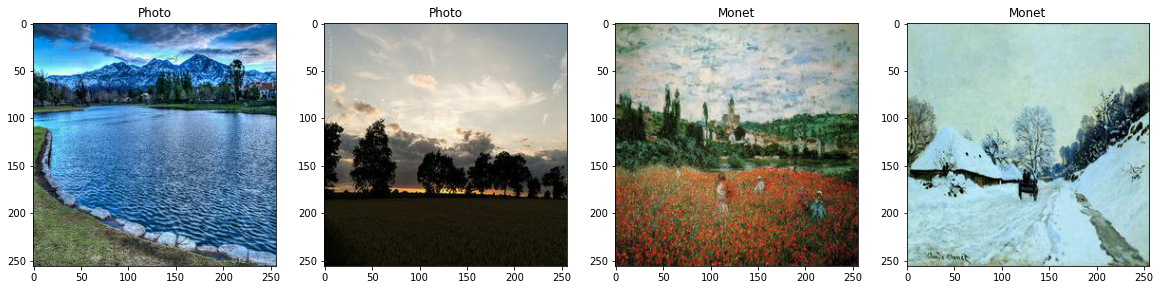

In [3]:
fig = plt.figure(figsize=(20,20))
plt.subplot(141)
plt.title('Photo')
plt.imshow((ImagesDataset[121][0]).permute(1, 2, 0)*0.5+0.5)
plt.subplot(142)
plt.title('Photo')
plt.imshow((ImagesDataset[120][0]).permute(1, 2, 0)*0.5+0.5)

plt.subplot(143)
plt.title('Monet')
plt.imshow((ImagesDataset[1][1]).permute(1, 2, 0)*0.5+0.5)
plt.subplot(144)
plt.title('Monet')
plt.imshow((ImagesDataset[2][1]).permute(1, 2, 0)*0.5+0.5)


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Let's build our model!
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For this competition, I generate images in the style of Monet. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

My task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

### Build generator!

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s.


In [5]:
class ResidualBlock(nn.Module):

    def __init__(self, size):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(size, size, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(size),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(size, size, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.BatchNorm2d(size),
        )

    def forward(self, x):
        return nn.ReLU()(x + self.block(x))

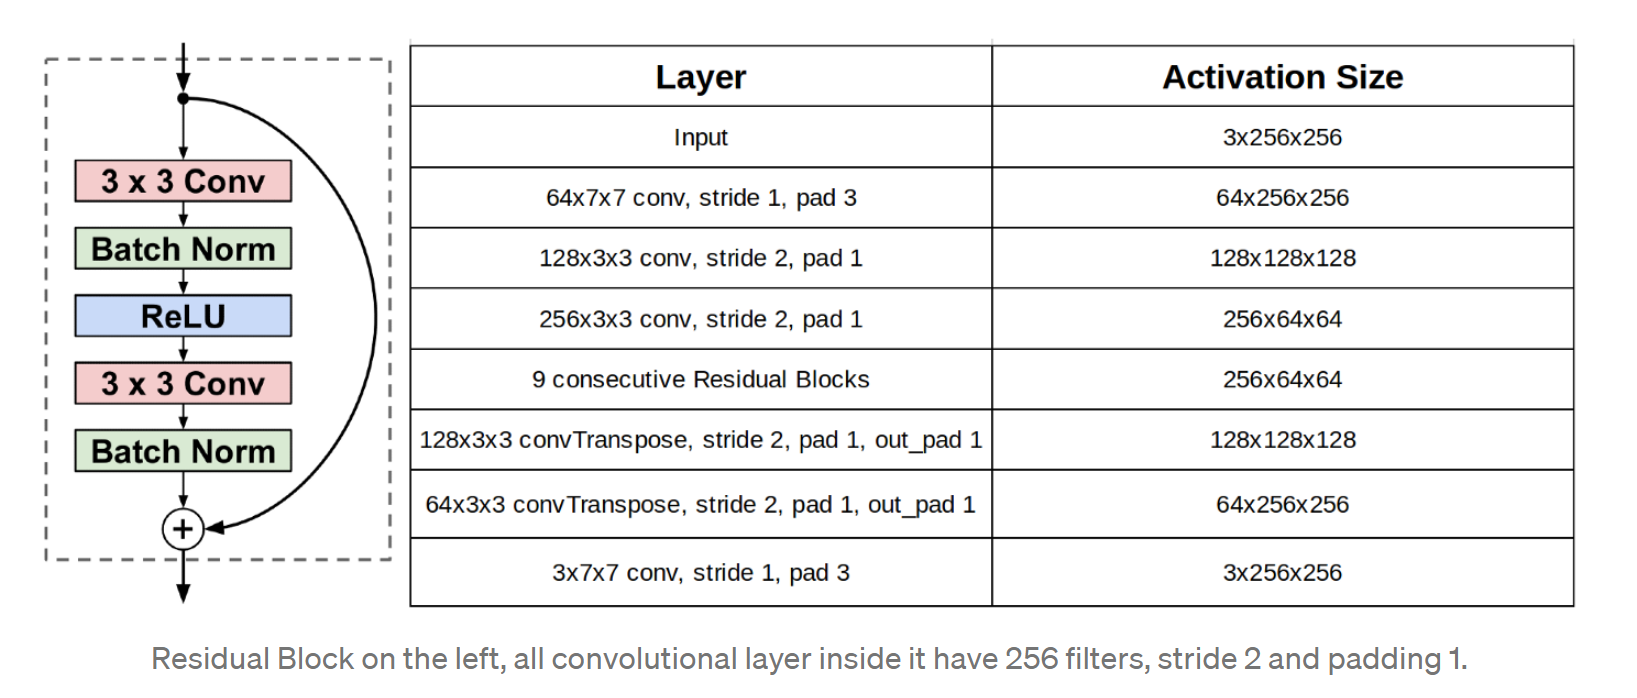


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = [
            # input = [3, 256, 256]
            nn.Conv2d(3, 64, 7, 1, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        ]
        self.encode.extend([ResidualBlock(256)] * 9)
        
        self.encode.extend([
            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        
            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 3, 7, 1, 3, bias=False),
            nn.Tanh()
        
        ])
        
        self.encode = nn.Sequential(*self.encode)
        
    def forward(self, x):
        return self.encode(x)

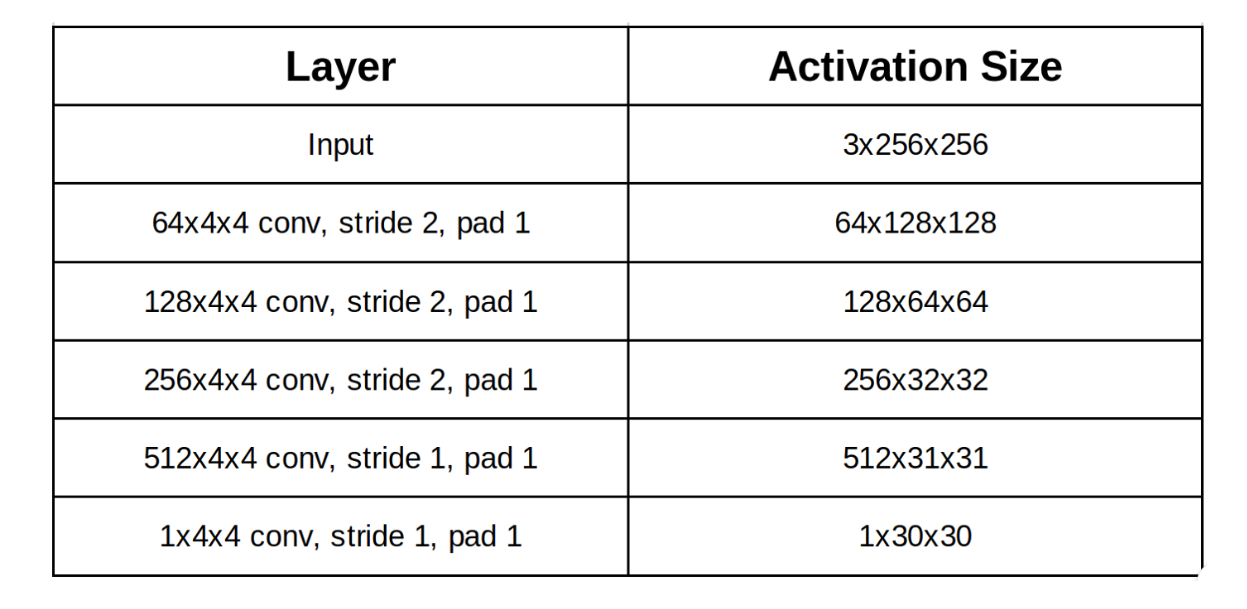


### Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.decode = nn.Sequential( 
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.Conv2d(256, 512, 4, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.Conv2d(512, 1, 4, 1, 1, bias=False),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        return self.decode(x)

In [8]:
class ReplayBuffer:
    def __init__(self, max_size = 50):
        self.max_size = max_size
        self.data = []
        
    def push_and_pop(self, data):
        data = data.detach()
        res = []
        for element in data:
            if len(self.data) < self.max_size:
                self.data.append(element)
                res.append(element)
            else:
                if np.random.uniform(0, 1) > 0.5:
                    i = np.random.randint(0, self.max_size - 1)
                    res.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    res.append(element)
        return torch.stack(res)

### Compile the model



The convolution module and batchnorm will be assigned different weight data througnt a function named weight_init. The the discriminator and the generator also utilize two oprimizer respectively,named Nadam and Adadelta.Additionally, we will opitimize learning rate at epoch 5.

In [9]:
G_1, G_2 = Generator().to(device), Generator().to(device)
D_1, D_2 = Discriminator().to(device), Discriminator().to(device)

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


G_1.apply(weights_init)
G_2.apply(weights_init)
D_1.apply(weights_init)
D_2.apply(weights_init)

Discriminator(
  (decode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(1, eps=1e-05, momentum=0.1

In [11]:
optimizer_G1, optimizer_G2 = torch.optim.NAdam(G_1.parameters()), torch.optim.NAdam(G_2.parameters())
optimizer_D1, optimizer_D2 = torch.optim.Adadelta(D_1.parameters()), torch.optim.Adadelta(D_2.parameters())

scheduler_G1 = torch.optim.lr_scheduler.MultiStepLR(optimizer_G1, milestones=[5])
scheduler_G2 = torch.optim.lr_scheduler.MultiStepLR(optimizer_G2, milestones=[5])

scheduler_D1 = torch.optim.lr_scheduler.MultiStepLR(optimizer_D1, milestones=[5])
scheduler_D2 = torch.optim.lr_scheduler.MultiStepLR(optimizer_D2, milestones=[5])

In [12]:
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)
lmbd = 10
identity_w = 0.5 * lmbd
cycle_w = 0.1 * lmbd
batch_size =4
num_epoch = 4

In [13]:
loader = DataLoader(ImagesDataset, batch_size=batch_size, shuffle=True)
photo_buf = ReplayBuffer()
monet_buf = ReplayBuffer()

# Training

During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.


In [ ]:
G_losses = []
D_losses = []
iters = 0
best_g = 100
best_d = 100
G_1.train(), G_2.train(), D_1.train(), D_2.train()



for e in range(1, num_epoch):
    for photo, monet in loader:
        
        photo = photo.to(device)
        monet = monet.to(device)
        real_label = torch.ones(photo.size()[0], 1, 30, 30,
                                         device=device, requires_grad=False)
        

        fake_label = torch.zeros(photo.size()[0], 1, 30, 30,
                                           device=device, requires_grad=False)
        
        # GENERATORS
        optimizer_G1.zero_grad()
        optimizer_G2.zero_grad()
        
        identity_loss_photo = identity_loss(G_2(photo), photo) * identity_w
        identity_loss_monet = identity_loss(G_1(monet), monet) * identity_w
        
        fake_photo = G_2(monet)
        #fake_photo_d = D_1(fake_photo)
        #adversarial_loss_2 = adversarial_loss(fake_photo_d, real_label)
        
        adversarial_loss_2 = adversarial_loss(D_1(fake_photo), real_label)
        
        fake_monet = G_1(photo)
        #fake_monet_d = D_2(fake_monet)
        #adversarial_loss_1 = adversarial_loss(fake_monet_d, real_label)
        
        adversarial_loss_1 = adversarial_loss(D_2(fake_monet), real_label)
        
        monet2photo = G_2(fake_monet)
        cycle_loss_p2m2p = cycle_loss(monet2photo, photo) * cycle_w
        
        photo2monet = G_1(fake_photo)
        cycle_loss_m2p2m = cycle_loss(photo2monet, monet) * cycle_w
        
        total_loss = identity_loss_photo + identity_loss_monet + adversarial_loss_1 + adversarial_loss_2 +\
                     cycle_loss_p2m2p + cycle_loss_m2p2m
        
        total_loss.backward()
        optimizer_G1.step()
        optimizer_G2.step() 
        
        G_losses.append(total_loss.item())
        
        # DISCRIMINATORS
        optimizer_D1.zero_grad()
        
        
        loss_real = adversarial_loss(D_1(photo), real_label)
        fake_photo_ = photo_buf.push_and_pop(fake_photo)
        loss_fake = adversarial_loss(D_1(fake_photo_.detach()), fake_label)
    
        loss_D_1 = (loss_real + loss_fake) / 2

        loss_D_1.backward()
        optimizer_D1.step()
        
        optimizer_D2.zero_grad()
        
        loss_real = adversarial_loss(D_2(monet), real_label)
        fake_monet_ = monet_buf.push_and_pop(fake_monet)
        loss_fake = adversarial_loss(D_2(fake_monet_.detach()), fake_label)

        loss_D_2 = (loss_real + loss_fake) / 2

        loss_D_2.backward()
        optimizer_D2.step()

        loss_D = (loss_D_1 + loss_D_2) / 2
        
        D_losses.append(loss_D.item())
                    
        scheduler_G1.step()
        scheduler_G2.step()
        scheduler_D1.step()
        scheduler_D2.step()
        
        if iters % 100 == 0:
            print(f'{e}/{num_epoch}, {iters/len(loader)}')
            print(f'  G loss: {total_loss}')
            print(f'  D loss: {loss_D}')
            print()
            #torch.save(state_dict,"net_params.pth")
            
        if (total_loss < best_g and loss_D < best_d):
            torch.save(G_1.state_dict(), "./G_1.pth")
            torch.save(G_2.state_dict(), "./G_2.pth")
            torch.save(D_1.state_dict(), "./D_1.pth")
            torch.save(D_2.state_dict(), "./D_2.pth")
        iters += 1


In [14]:
os.chdir(r'/kaggle/input/parameter')
import IPython
from IPython.display import FileLink
FileLink('./G_1.pth')
FileLink('./G_2.pth')
FileLink('./D_1.pth')
FileLink('./D_2.pth')

/kaggle/input/parameter/D_2.pth

In [15]:
G_1.load_state_dict(torch.load('./G_1.pth', map_location='cpu'))
G_2.load_state_dict(torch.load('./G_2.pth', map_location='cpu'))
D_1.load_state_dict(torch.load('./D_1.pth', map_location='cpu'))
D_2.load_state_dict(torch.load('./D_2.pth', map_location='cpu'))

<All keys matched successfully>

In [16]:
ImagesDataset[0][0].view(1, 3, 256, 256).size()

torch.Size([1, 3, 256, 256])

In [17]:
unnorm = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

# Visualize our Monet-esque photos

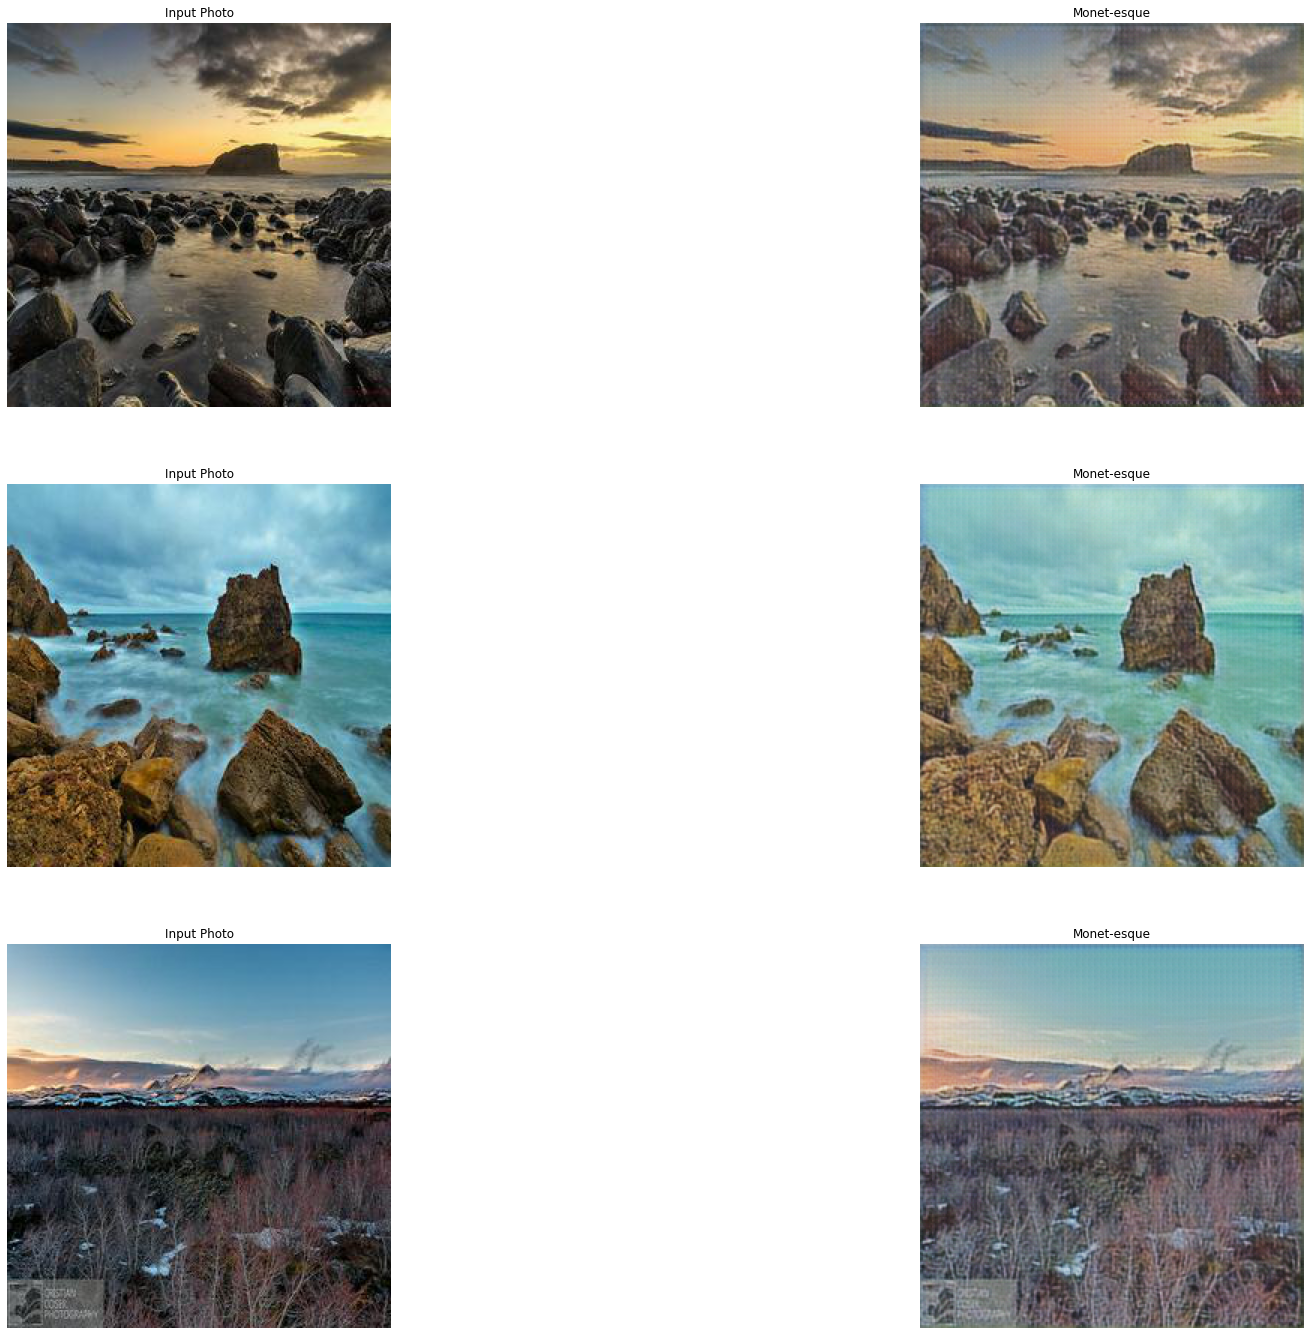

In [18]:
_, ax = plt.subplots(3, 2, figsize=(30, 24))
G_1.eval()
for i, img in enumerate([ImagesDataset[50][0], ImagesDataset[150][0], ImagesDataset[250][0]]):
    prediction = G_1(img.view(1, 3, 256, 256).to(device))[0].permute(1, 2, 0).cpu().detach().numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    #img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    img = unnorm(img).permute(1, 2, 0)
    ax[i, 0].imshow(img, )
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
! mkdir /kaggle/working/images
sub_loader = DataLoader(ImagesDataset, batch_size=1)

i = 1
for img, _ in sub_loader:
    prediction = G_1(img.to(device))[0].permute(1, 2, 0).cpu().detach().numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    i += 1


In [ ]:
len(os.listdir('/kaggle/working/images'))

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")